In [1]:
## Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

# General libraries
import os
import json
import random
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# TensorFlow and deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Flatten, Input, LayerNormalization, MultiHeadAttention, Layer, Embedding
from tensorflow.keras.models import Model

# ViT specific imports (for Vision Transformer)
from tensorflow.keras.applications import EfficientNetB0  # If using a base model, can switch to ViT later
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


## Data Import

In [2]:
try:
    kaggle_credentials = json.load(open("kaggle.json"))
    os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
    os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]
except FileNotFoundError:
    print("kaggle.json file not found. Please place it in the directory.")
except KeyError:
    print("Error: Invalid JSON format in kaggle.json.")



# #Load Kaggle API credentials from the kaggle.json file and set them as environment variables.
# This allows the script to authenticate with the Kaggle API automatically.

if not os.path.exists('plantvillage dataset'): 
    if not os.path.exists('plantvillage-dataset.zip'):
        # Download the dataset if the ZIP file doesn't exist
        os.system('kaggle datasets download -d abdallahalidev/plantvillage-dataset')
    
    # Extract the dataset if the directory doesn't exist
    with ZipFile('plantvillage-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('plantvillage dataset')


##  Focus on Color Images

Number of images in 'color': 38
First 5 classes in 'color': ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


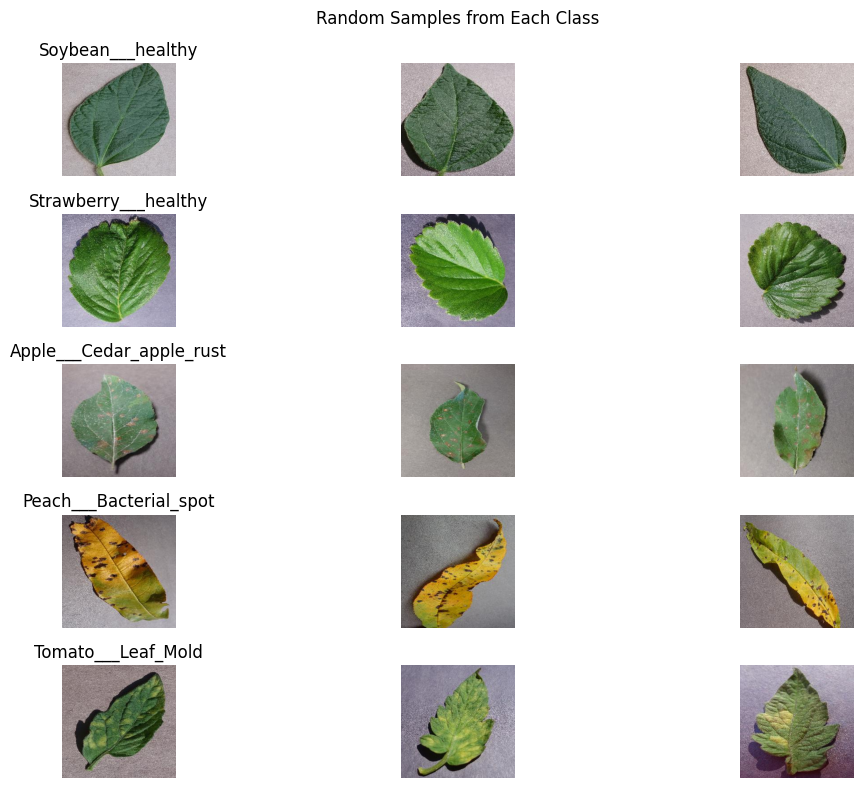

In [3]:
# Dataset directory path for colored images
color_dir = 'plantvillage dataset/color'

# Check if the 'color' directory exists
if os.path.exists(color_dir):
    print(f"Number of images in 'color': {len(os.listdir(color_dir))}")
    
    # Print the first 5 classes in the color directory
    class_dirs = [d for d in os.listdir(color_dir) if os.path.isdir(os.path.join(color_dir, d))]
    print(f"First 5 classes in 'color': {class_dirs[:5]}")

    # Visualize random samples from the colored dataset
    def visualize_random_samples(color_dir, classes=5, samples_per_class=3):
        class_dirs = [d for d in os.listdir(color_dir) if os.path.isdir(os.path.join(color_dir, d))]
        if len(class_dirs) < classes:
            classes = len(class_dirs)
            print(f"Reduced number of classes to {classes} due to available directories.")
        
        # Randomly select classes and visualize images
        selected_classes = random.sample(class_dirs, classes)
        fig, axes = plt.subplots(nrows=classes, ncols=samples_per_class, figsize=(12, 8))
        fig.suptitle('Random Samples from Each Class')

        for i, class_name in enumerate(selected_classes):
            class_path = os.path.join(color_dir, class_name)
            image_files = os.listdir(class_path)
            selected_images = random.sample(image_files, samples_per_class)

            for j, image_name in enumerate(selected_images):
                img_path = os.path.join(class_path, image_name)
                img = mpimg.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                if j == 0:
                    axes[i, j].set_title(class_name)
        plt.tight_layout()
        plt.show()

    visualize_random_samples(color_dir)
else:
    print(f"Directory '{color_dir}' does not exist.")


### Setup the Vision Transformer (ViT) Model Architecture
Now, let's define the Vision Transformer (ViT) model using TensorFlow/Keras. We'll first load and preprocess the data and then build the ViT model.

In [4]:
@tf.keras.utils.register_keras_serializable()
class PatchExtractor(Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Flatten the patches
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [-1, patches.shape[1] * patches.shape[2], patch_dim])
        return patches


In [5]:
# Image Parameters for ViT
img_size = 128  # but Vision Transformers often use higher input sizes like 224x224
batch_size = 16  # Batch size suited for ViT

# ImageDataGenerator for augmenting and preprocessing the images
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% of data for validation
)

# Train and Validation Generators
train_generator = data_gen.flow_from_directory(
    color_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

validation_generator = data_gen.flow_from_directory(
    color_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


### Create the Vision Transformer Model
The Vision Transformer (ViT) processes images by splitting them into patches and applying self-attention mechanisms similar to the Transformer models used in NLP tasks. We create a simple Vision Transformer model using tensorflow.keras.layers.

In [6]:
# Custom layer for extracting patches from images
class PatchExtractor(Layer):
    def __init__(self, patch_size):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        # Flatten the patches
        patch_dim = patches.shape[-1]
        patches = tf.reshape(patches, [-1, patches.shape[1] * patches.shape[2], patch_dim])
        return patches

# Vision Transformer Model
def build_vit_model(input_shape, num_classes, patch_size=16, embedding_dim=64, num_heads=4, ff_dim=128, num_transformer_layers=6):
    inputs = Input(shape=input_shape)
    
    # Extract patches from the input images
    patches = PatchExtractor(patch_size)(inputs)
    
    # Embed the patches
    patch_embeddings = Dense(embedding_dim)(patches)

    # Apply Transformer blocks
    for _ in range(num_transformer_layers):
        # Multi-head Self Attention
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(patch_embeddings, patch_embeddings)
        attention_output = LayerNormalization()(attention_output + patch_embeddings)
        
        # Feedforward layers
        ff_output = Dense(ff_dim, activation="relu")(attention_output)
        ff_output = Dense(embedding_dim)(ff_output)
        patch_embeddings = LayerNormalization()(ff_output + attention_output)
    
    # Classification Head
    x = Flatten()(patch_embeddings)
    x = Dense(512, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Model
    model = Model(inputs, outputs)
    return model

# Build the model
vit_model = build_vit_model(input_shape=(img_size, img_size, 3), num_classes=train_generator.num_classes)
vit_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extractor     │ (None, 64, 768)   │          0 │ input_layer[0][0] │
│ (PatchExtractor)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 64)    │     49,216 │ patch_extractor[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64, 64)    │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64)    │          0 │ dense_2[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 64)    │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,716,646 (10.36 MB)

 Trainable params: 2,716,646 (10.36 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model
We will compile the model with the Adam optimizer and train it on the dataset.

In [7]:
# Compile the ViT model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the ViT model
history = vit_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/10


c:\Users\pascal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 556s 197ms/step - accuracy: 0.4526 - loss: 2.0086 - val_accuracy: 0.7601 - val_loss: 0.7800
Epoch 2/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 80us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.3009
Epoch 3/10


c:\Users\pascal\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 507s 186ms/step - accuracy: 0.7905 - loss: 0.6638 - val_accuracy: 0.8137 - val_loss: 0.5935
Epoch 4/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 3.6954e-05
Epoch 5/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 504s 185ms/step - accuracy: 0.8558 - loss: 0.4493 - val_accuracy: 0.8587 - val_loss: 0.4322
Epoch 6/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 7/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 480s 177ms/step - accuracy: 0.8845 - loss: 0.3533 - val_accuracy: 0.8948 - val_loss: 0.3296
Epoch 8/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0326
Epoch 9/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 483s 178ms/step - accuracy: 0.9028 - loss: 0.2938 - val_accuracy: 0.9085 - val_loss: 0.2761
Epoch 10/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 19us/ste

## Evaluate and Save the Model
After training, we can evaluate the model and save it.

In [8]:
# Evaluate the model
val_loss, val_accuracy = vit_model.evaluate(validation_generator, steps=validation_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")




678/678 ━━━━━━━━━━━━━━━━━━━━ 68s 100ms/step - accuracy: 0.9133 - loss: 0.2606
Validation Accuracy: 91.00%


## Model Accuracy and Loss Plotting 

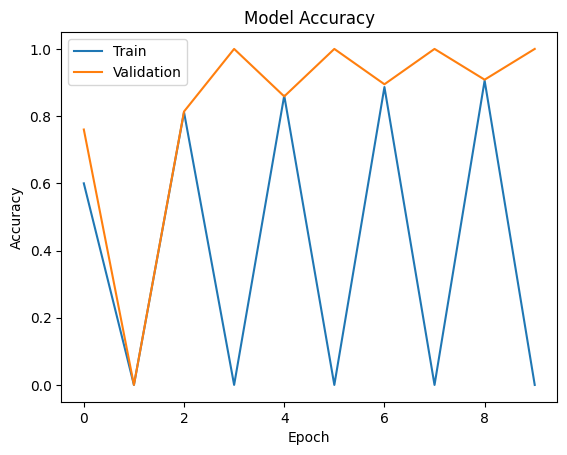

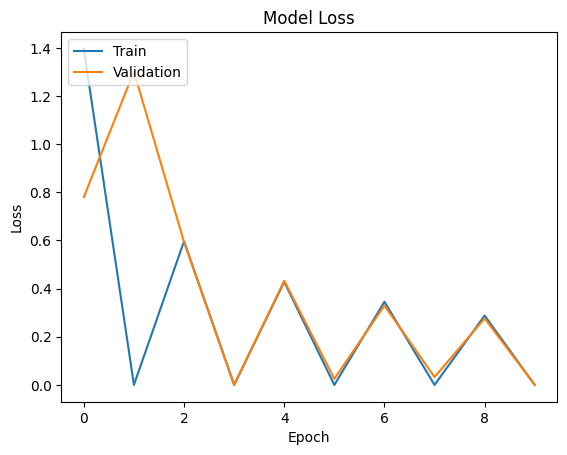

In [9]:


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Image Preprocessing and Prediction Pipeline

In [10]:

# Function to load and preprocess images for the ViT model
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]  # Remove str() conversion here
    return predicted_class_name


### Class Mapping 

In [11]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Save the class indices as a JSON file
import json
json.dump(class_indices, open('class_indices_vit.json', 'w'))


### Model Testing (Using the Trained Model for Prediction)

In [12]:
print(class_indices)


{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To

In [13]:
from PIL import Image  

# Test the model on a single image
image_path = r"C:\Users\pascal\Desktop\New Projects\plant-disease-prediction\plant-disease-prediction\plantvillage dataset\test_images\test_potato_early_blight.jpg" 
predicted_class_name = predict_image_class(vit_model, image_path, class_indices)
print(f"Predicted Class: {predicted_class_name}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
Predicted Class: Potato___Early_blight


### Save Model

In [14]:
vit_model.save('vit_plant_disease_model.h5')
vit_model.save('vit_plant_disease_model.keras')
